In [1]:
import numpy as np 
import pandas as pd 
import pickle

# visualizatioion pkg 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format='retina'

import sys
sys.path.append('..')

from utils.viz import viz 
from utils.model import *  
from utils.fig_fn import *
viz.get_style()

In [2]:
data_set = 'exp2'
models = ['rlPG_fea', 'caPG_fea', 'ecPG_fea']
method = 'map'
dpi = 300
to_pdf = True

### Fig 5A: learning curve 

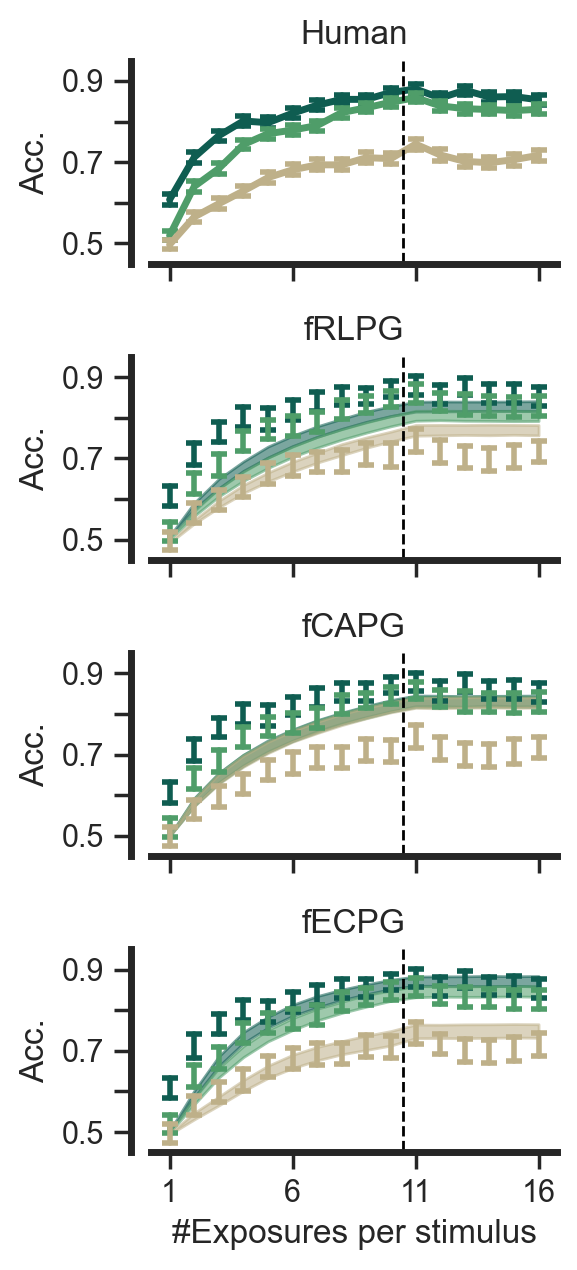

In [3]:
fig, ax = plt.subplots(len(models)+1, 1, figsize=(3, 6.5), sharex=True)
learning_curve_exp2(ax[0], get_sim_data(data_set, 'human', method=method), 
                    human=True)
ax[0].set_box_aspect(.5)
ax[0].set_title('Human')
for i, model in enumerate(models):
    learning_curve_exp2(ax[i+1], get_sim_data(data_set, model, method=method),
                        with_target_data_set=data_set)
    ax[i+1].set_box_aspect(.5)
    ax[i+1].set_title(eval(model).name)
fig.tight_layout()
if to_pdf: plt.savefig(f'../figures/{data_set}/Fig6A_learnCurve.pdf', dpi=dpi)

### Fig5C: Human and model probe policy 

In [4]:
def viz_probe(axs, data_set, models, method, goodPoor=None):
    n = len(models) 
    for i, m in enumerate(models):
        if m == 'human':
            fname = f'{pth}/../data/{data_set}-human.csv'
            s = 1
        else:
            fname = f'{pth}/../simulations/{data_set}/{m}/sim-{method}.csv'
            s = 10
        data = pd.read_csv(fname, index_col=0)
        sel_data = data.query('group=="probe"').reset_index()
        for j, cond in enumerate(['cons', 'cont', 'conf']):
            ax = axs[i, j] if n > 1 else axs[j]
            sdata = sel_data.query(f'block_type=="{cond}"').copy()
            if goodPoor is not None: sdata = sdata.query(f'goodPoor=="good"').copy()
            # yvar = 'r' if m=='human' else 'acc' 
            if m!='human': sdata['r'] = sdata['acc']
            gdata = sdata.groupby(by=['sub_id', 'a', 'block_type']).count()['r'].reset_index()
            ptable = gdata.pivot_table(values='r', index='sub_id', columns='a').fillna(0) / (6*s)
            ptable.columns = [0, 1, 2, 3]
            ptable = ptable.reset_index()
            ptable = ptable.melt(id_vars='sub_id', value_vars=[0, 1, 2, 3]
                        ).rename(columns={'variable': 'a', 'value':'prop'})
            
            sns.stripplot(x='a', y='prop', data=ptable, 
                        color=viz.Pal_type[j], #dodge=True, 
                        edgecolor='none', size=2.8,
                        jitter=True, alpha=.3,
                        legend=False, zorder=2,
                        ax=ax)
            sns.violinplot(x='a', y='prop', data=ptable,
                        legend=False, alpha=.3, inner=None,
                        density_norm='width', edgecolor=[.8]*3,
                        color=viz.Pal_type[j],
                        ax=ax)
            sns.barplot(x='a', y='prop', data=ptable,
                        width=.75, errorbar=('ci', 95), lw=2.5,
                        edgecolor=viz.Pal_type[j], 
                        facecolor=viz.Pal_type[j].tolist()+[.2],
                        err_kws={'color': [.2, .2, .2], 'linewidth': 2.5},
                        capsize=.2,
                        color='w', ax=ax)
            ax.set_box_aspect(.9)
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_ylim([0, 1.1])
            if j==1: ax.set_title(eval(m).name)
            ax.spines['left'].set_position(('axes',-0.05))
            for pos in ['bottom', 'left']: ax.spines[pos].set_linewidth(2.5)
            ax.set_xticks(range(4))
            ax.set_xticklabels([r'$a_1$', r'$a_2$', r'$a_3$', r'$a_4$'])


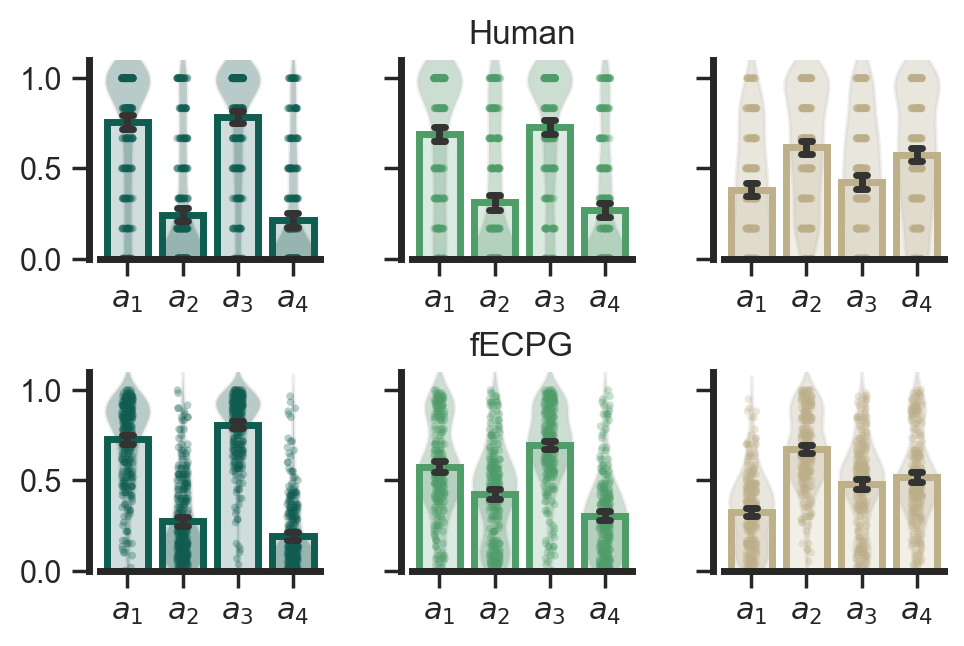

In [5]:
models = ['human', 'ecPG_fea']
fig, axs = plt.subplots(len(models), 3, figsize=(1.6*3.2, len(models)*1.65), sharey=True)
viz_probe(axs, 'exp2', models, method='map')
fig.tight_layout()
if to_pdf: plt.savefig(f'../figures/{data_set}/Fig6B_probeData.pdf', dpi=dpi)


### Fig5D: correlation matrix 


rlPG_fea-cons:
            n         r         CI95%     p-val     power
spearman  626  0.190182  [0.11, 0.26]  0.000002  0.997807

caPG_fea-cons:
            n         r         CI95%         p-val  power
spearman  626  0.351004  [0.28, 0.42]  1.375347e-19    1.0

ecPG_fea-cons:
            n        r         CI95%         p-val  power
spearman  626  0.69566  [0.65, 0.73]  1.053862e-91    1.0

rlPG_fea-cont:
            n         r         CI95%     p-val     power
spearman  626  0.139257  [0.06, 0.22]  0.000475  0.938363

caPG_fea-cont:
            n         r         CI95%         p-val     power
spearman  626  0.207555  [0.13, 0.28]  1.607383e-07  0.999518

ecPG_fea-cont:
            n         r         CI95%         p-val  power
spearman  626  0.606508  [0.55, 0.65]  3.763570e-64    1.0

rlPG_fea-conf:
            n         r         CI95%     p-val     power
spearman  626  0.108285  [0.03, 0.19]  0.006691  0.774999

caPG_fea-conf:
            n         r         CI95%     p-val 

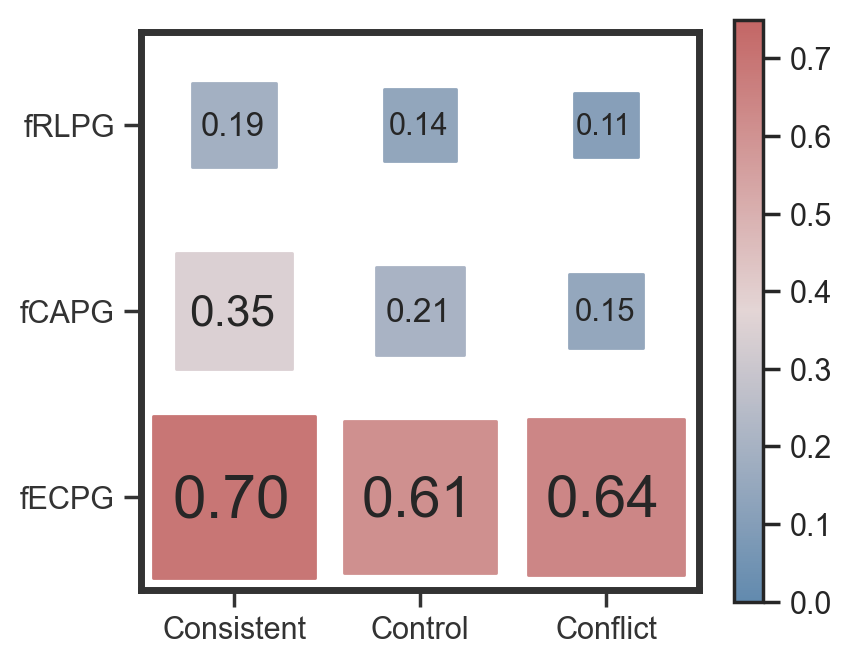

In [6]:
models = ['rlPG_fea', 'caPG_fea', 'ecPG_fea']
corr_data = get_prob_corr_matrix('exp2', models=models, method=method)
fig, ax = plt.subplots(figsize=(4.5, 1.8+1.5*len(models)))
show_prob_corr_matrix(ax, corr_data.transpose(), models=models, 
        font_scale=45, marker_scale=4900, cbar_scale=.6)
if to_pdf: plt.savefig(f'../figures/{data_set}/Fig6C_corr_mat.pdf', dpi=dpi)